In [1]:
from collections import defaultdict
import os
import csv
import sys
import cv2
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import shapely
import numpy as np
import tifffile as tiff
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def mask_image(IM_ID):
    
    x_max = y_min = None
    for _im_id, _x, _y in csv.reader(open('./grid_sizes.csv')):
        if _im_id == IM_ID:
            x_max, y_min = float(_x), float(_y)
            break
    
    maxInt = sys.maxsize
    while True:
        # decrease the maxInt value by factor 10 
        # as long as the OverflowError occurs.

        try:
            csv.field_size_limit(maxInt)
            break
        except OverflowError:
            maxInt = int(maxInt/10)
     
    # Load train poly with shapely
    component = []
    polyline = []
    for _im_id, _poly_type, _poly in csv.reader(open('./train_wkt_v4.csv')):
        if _im_id == IM_ID:
            if _poly != 'MULTIPOLYGON EMPTY':
                component.append(_poly_type)
                polyline.append(shapely.wkt.loads(_poly))
    
    
    # Read image with tiff
    im_rgb = tiff.imread('./three_band/{}.tif'.format(IM_ID)).transpose([1, 2, 0])
    im_size = im_rgb.shape[:2]
    
    #Scale polygons to match image:
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    w_ = w * (w / (w + 1))
    h_ = h * (h / (h + 1))
    x_scaler = w_ / x_max
    y_scaler = h_ / y_min
    
    train_polygons_scaled = []
    for poly in polyline:
        train_polygons_scaled.append(shapely.affinity.scale(poly, xfact=x_scaler, yfact=y_scaler, origin=(0, 0, 0)))
    train_polygons = pd.DataFrame({'component': component, 'polyline': train_polygons_scaled})
    
    '''color_dic = {'1': (178,34,34),
                 '2': (255,69,0),
                 '3': (169,169,169),
                 '4': (244,164,96),
                 '5': (154,205,50),
                 '6': (0,100,0),
                 '7': (0,0,205),
                 '8': (0,0,205),
                 '9': (128,0,128),
                 '10': (255,20,147)}'''
    
    #msk=np.zeros(im_size, np.uint8)
    R = np.zeros(im_size, np.uint8)
    G = np.zeros(im_size, np.uint8)
    B = np.zeros(im_size, np.uint8)
    for m in range(train_polygons.shape[0]):  
        if (train_polygons.values[m,0] == '1') or (train_polygons.values[m,0] == '2'):
            img_mask = np.zeros(im_size, np.uint8)
            int_coords = lambda x: np.array(x).round().astype(np.int32)
            exteriors = [int_coords(poly.exterior.coords) for poly in train_polygons.values[m,1]]
            interiors = [int_coords(pi.coords) for poly in train_polygons.values[m,1]
                         for pi in poly.interiors]
            cv2.fillPoly(img_mask, exteriors, 1)
            cv2.fillPoly(img_mask, interiors, 0)
            '''R = np.maximum(R,color_dic[train_polygons.values[m,0]][0]*img_mask)
            G = np.maximum(G,color_dic[train_polygons.values[m,0]][1]*img_mask)
            B = np.maximum(B,color_dic[train_polygons.values[m,0]][2]*img_mask)'''
            R = np.maximum(R,255*img_mask)
            G = np.maximum(G,255*img_mask)
            B = np.maximum(B,255*img_mask)
                
    return cv2.merge([R, G, B])

In [3]:
def scale_percentile(matrix):
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    matrix = (matrix - mins[None, :]) / maxs[None, :]
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)
    return matrix

In [4]:
'''def crop_image(IM_ID):
    raw_img = tiff.imread('./three_band/{}.tif'.format(IM_ID)).transpose([1, 2, 0])
    mask = mask_image(IM_ID)
    w,h = raw_img.shape[:2]
    k=1
    hstart=0
    for i in range(1,9):
        hend = (h/8)*i
        wstart=0 
               
        for j in range(1,9):
            wend = (w/8)*j
            FOLDER_NAME = IMG_NAME = IM_ID+'_'+str(k)
            k=k+1
            os.makedirs('./train/{}'.format(FOLDER_NAME))
            temp = raw_img[int(hstart):int(hend), int(wstart):int(wend)]
            #img = cv2.resize(temp,(224, 224), cv2.INTER_AREA)
            img = img/np.max(img)
            alpha = np.ones(img.shape[:2]) 
            alpha = alpha * 255
            rgba = np.stack([img[:,:,0], img[:,:,1], img[:,:,2], alpha])
            rgba = rgba.transpose([1, 2, 0])
            tiff.imsave('./train/{}/{}.tif'.format(FOLDER_NAME, IMG_NAME), img)
            
            image = mask[int(hstart):int(hend), int(wstart):int(wend)]
            #image = cv2.resize(image,(224, 224), cv2.INTER_AREA)         
            #alp = []
            row, col = image.shape[:2]
            for i in range(row):
                #temp = []
                for j in range(col):
                    if (image[i][j][0] == 0) and (image[i][j][1] == 0) and (image[i][j][2] == 0):
                        image[i][j][0] = 255
                        image[i][j][1] = 255
                        image[i][j][2] = 255
                    #else:
                    #    temp.append(255)
                #alp.append(temp)
        
            #rgba = np.stack([image[:,:,0], image[:,:,1], image[:,:,2], alp])
            #rgba = rgba.transpose([1, 2, 0])
            tiff.imsave('./train/{}/{}.tif'.format(FOLDER_NAME, 'mask'),image/255)
            wstart = wend
        hstart = hend'''

"def crop_image(IM_ID):\n    raw_img = tiff.imread('./three_band/{}.tif'.format(IM_ID)).transpose([1, 2, 0])\n    mask = mask_image(IM_ID)\n    w,h = raw_img.shape[:2]\n    k=1\n    hstart=0\n    for i in range(1,9):\n        hend = (h/8)*i\n        wstart=0 \n               \n        for j in range(1,9):\n            wend = (w/8)*j\n            FOLDER_NAME = IMG_NAME = IM_ID+'_'+str(k)\n            k=k+1\n            os.makedirs('./train/{}'.format(FOLDER_NAME))\n            temp = raw_img[int(hstart):int(hend), int(wstart):int(wend)]\n            #img = cv2.resize(temp,(224, 224), cv2.INTER_AREA)\n            img = img/np.max(img)\n            alpha = np.ones(img.shape[:2]) \n            alpha = alpha * 255\n            rgba = np.stack([img[:,:,0], img[:,:,1], img[:,:,2], alpha])\n            rgba = rgba.transpose([1, 2, 0])\n            tiff.imsave('./train/{}/{}.tif'.format(FOLDER_NAME, IMG_NAME), img)\n            \n            image = mask[int(hstart):int(hend), int(wstart):int(w

In [5]:
def crop_image(IM_ID):
    raw_img = tiff.imread('./three_band/{}.tif'.format(IM_ID)).transpose([1, 2, 0])
    mask = mask_image(IM_ID)
    w,h = raw_img.shape[:2]
    k=1
    hstart=0
    hend = 0
    i = 1
    
    while (hend<h):
        hend = 224*i
        i = i+1
        wstart=0 
        wend = 0
        j = 1
        while (wend < w) and (hend < h):
            wend = 224*j
            j = j+1
            #print(str(int(hstart))+' '+str(int(hend))+'->'+str(int(wstart))+' '+str(int(wend)))
            FOLDER_NAME = IMG_NAME = IM_ID+'_'+str(k)
            k=k+1
            os.makedirs('./train/{}'.format(FOLDER_NAME))
            img = raw_img[int(hstart):int(hend), int(wstart):int(wend)]
            #img = cv2.resize(temp,(224, 224), cv2.INTER_AREA)
            #img = img/np.max(img)
            '''alpha = np.ones(img.shape[:2]) 
            alpha = alpha * 255
            rgba = np.stack([img[:,:,0], img[:,:,1], img[:,:,2], alpha])
            rgba = rgba.transpose([1, 2, 0])'''
            tiff.imsave('./train/{}/{}.tif'.format(FOLDER_NAME, IMG_NAME), img)
            
            image = mask[int(hstart):int(hend), int(wstart):int(wend)]
            #image = cv2.resize(image,(224, 224), cv2.INTER_AREA)         
            #alp = []
            '''row, col = image.shape[:2]
            for i in range(row):
                #temp = []
                for j in range(col):
                    if (image[i][j][0] == 0) and (image[i][j][1] == 0) and (image[i][j][2] == 0):
                        image[i][j][0] = 255
                        image[i][j][1] = 255
                        image[i][j][2] = 255
                    #else:
                    #    temp.append(255)
                #alp.append(temp)
        
            #rgba = np.stack([image[:,:,0], image[:,:,1], image[:,:,2], alp])
            #rgba = rgba.transpose([1, 2, 0])
            image/255'''
            tiff.imsave('./train/{}/{}.tif'.format(FOLDER_NAME, 'mask'),image)
            wstart = wend
        hstart = hend

In [6]:
train_wkt = pd.read_csv('./train_wkt_v4.csv')
img_ids = train_wkt['ImageId'].unique()
img_ids

array(['6040_2_2', '6120_2_2', '6120_2_0', '6090_2_0', '6040_1_3',
       '6040_1_0', '6100_1_3', '6010_4_2', '6110_4_0', '6140_3_1',
       '6110_1_2', '6100_2_3', '6150_2_3', '6160_2_1', '6140_1_2',
       '6110_3_1', '6010_4_4', '6170_2_4', '6170_4_1', '6170_0_4',
       '6060_2_3', '6070_2_3', '6010_1_2', '6040_4_4', '6100_2_2'],
      dtype=object)

(3348, 3403, 3)


(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x2549ee5d7f0>)

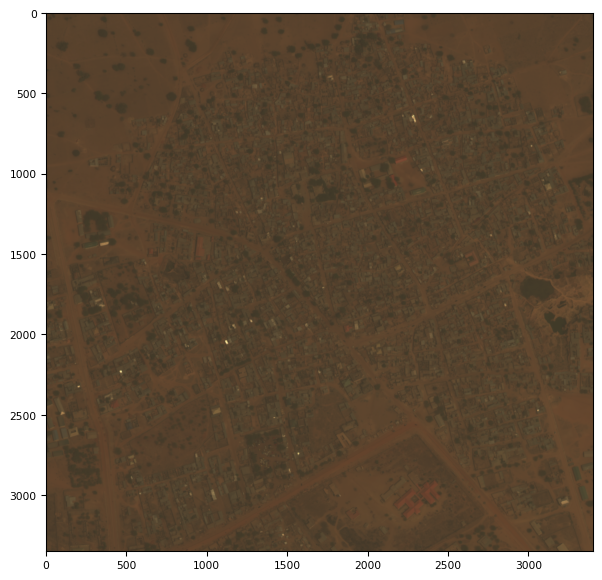

In [7]:
raw_img = tiff.imread('./three_band/{}.tif'.format('6120_2_2')).transpose([1, 2, 0])
print(raw_img.shape)
tiff.imshow(raw_img)

(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x2549f145240>)

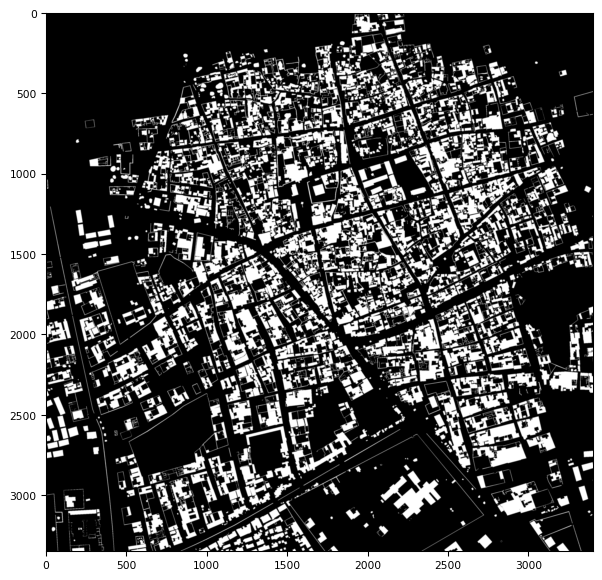

In [8]:
msk = mask_image('6120_2_2')
tiff.imshow(msk)

In [14]:
for ID in img_ids:
    crop_image(ID)
#crop_image('6120_2_2')

(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x20a8dfdcd30>)

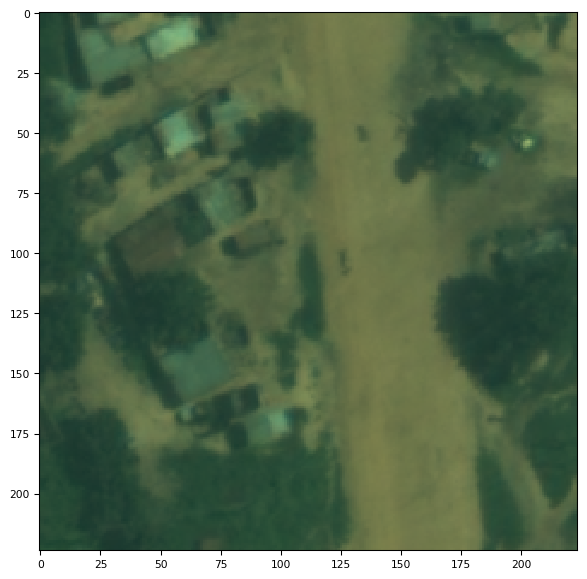

In [15]:
image = tiff.imread('./train/6100_2_3_91/6100_2_3_91.tif')
tiff.imshow(image)

[  0 255]


(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x20a8d8d1908>)

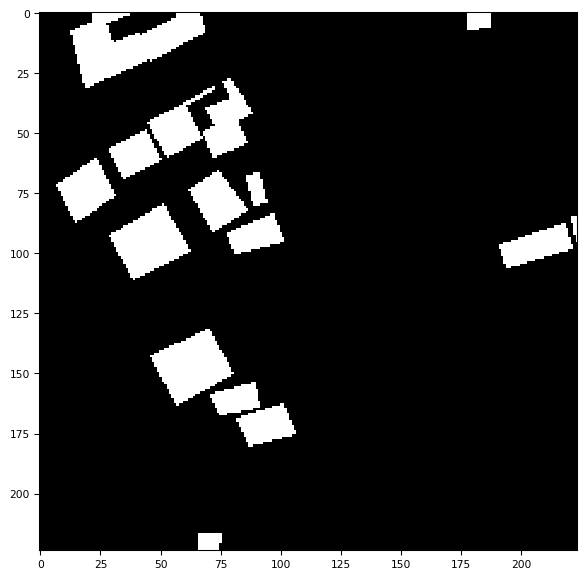

In [16]:
mask = tiff.imread('./train/6100_2_3_91/mask.tif')
print(np.unique(mask))
tiff.imshow(mask)

In [17]:
trainX = []
trainY = []
for root, dirs, files in os.walk('./train'):
    for dir_name in dirs:
        image = tiff.imread('./train/'+str(dir_name)+'/'+str(dir_name)+'.tif')
        #image = image/np.max(image)
        trainX.append(image)
        image = tiff.imread('./train/'+str(dir_name)+'/mask.tif')
        #image = image/255
        trainY.append(image)

In [23]:
import hickle as hkl
hkl.dump(X, 'trainX.hkl')
hkl.dump(Y, 'trainY.hkl')